In [ ]:
# Environment repair: install only NumPy/OpenCV/Matplotlib (no scikit-learn/scikit-image)
import sys, subprocess, shlex

print('Python executable:', sys.executable)

def pip(args):
    if isinstance(args, str):
        args = shlex.split(args)
    cmd = [sys.executable, '-m', 'pip'] + args
    print('>',' '.join(cmd))
    subprocess.check_call(cmd)

try:
    # Clean conflicting installs
    pip(['uninstall','-y','opencv-contrib-python','opencv-python','opencv-python-headless'])

    # Update build tools
    pip(['install','--upgrade','pip','setuptools','wheel'])

    # Install core deps only
    pip(['install','--upgrade','--force-reinstall','numpy'])
    pip(['install','--upgrade','--force-reinstall','opencv-contrib-python'])
    pip(['install','--upgrade','matplotlib'])

    # Verify imports and versions
    import numpy as _np
    import cv2 as _cv
    import matplotlib as _mpl

    print('numpy', _np.__version__)
    print('opencv', _cv.__version__)
    print('matplotlib', _mpl.__version__)
    print('MSER available:', hasattr(_cv, 'MSER_create'))

    print('\nIf imports still fail, please restart the Jupyter kernel and re-run imports.')
except Exception as e:
    print('Repair failed:', e)
    print('Try restarting the kernel, then re-run this cell.')

# OCR KTP Indonesia (Classical ML, No Deep Learning)

Pipeline lengkap berbasis OpenCV + ML klasik (MSER/Contour, HOG/Flatten, SVM/k-NN).

In [1]:
# Imports & Config (Classical ML only)
import os, sys, json, glob, math, itertools, string, random, pathlib, warnings
from dataclasses import dataclass, field
warnings.filterwarnings('ignore')

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Reproducibility
random.seed(42)
np.random.seed(42)

# Paths
ROOT = pathlib.Path(os.getcwd())
DEFAULT_DATASET_DIR = ROOT / 'dataset' / 'train'  # expected structure: 0..9
ALT_DATASET_DIR = pathlib.Path(r'l:\\OCR_KTP\\dataset\\train')
DATASET_DIR = DEFAULT_DATASET_DIR if DEFAULT_DATASET_DIR.exists() else ALT_DATASET_DIR
print('Dataset path:', DATASET_DIR)

# Utility: safe imread (color)
def imread_color(p):
    img = cv.imread(str(p), cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f'Cannot read image: {p}')
    return img

Dataset path: l:\OCR_KTP\dataset\train


In [2]:
# 1) Preprocessing: grayscale, blur, Otsu, morphology
from typing import Tuple

@dataclass
class PreprocessConfig:
    blur_ksize: int = 3
    morph_kernel: Tuple[int, int] = (3, 3)
    morph_iters: int = 1
    use_otsu: bool = True
    invert_for_text: bool = True  # text usually darker than background


def preprocess_for_text(img_bgr, cfg: PreprocessConfig = PreprocessConfig()):
    # grayscale
    gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)
    # blur
    k = max(1, cfg.blur_ksize)
    if k % 2 == 0:
        k += 1
    blur = cv.GaussianBlur(gray, (k, k), 0)
    # threshold (Otsu)
    if cfg.use_otsu:
        _, th = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    else:
        th = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, 10)
    # invert if text is dark
    if cfg.invert_for_text:
        th = 255 - th
    # morphology to strengthen text strokes
    kernel = cv.getStructuringElement(cv.MORPH_RECT, cfg.morph_kernel)
    morph = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel, iterations=cfg.morph_iters)
    return gray, th, morph

In [3]:
# 2) Text region detection: MSER and Contours + filtering
from typing import List

@dataclass
class DetectConfig:
    method: str = 'mser'  # 'mser' or 'contour'
    min_area: int = 80
    max_area: int = 50000
    aspect_range: Tuple[float, float] = (0.1, 15.0)
    merge_boxes: bool = True


def _filter_boxes(boxes, img_shape, cfg: DetectConfig):
    H, W = img_shape[:2]
    keep = []
    for (x, y, w, h) in boxes:
        area = w * h
        if area < cfg.min_area or area > cfg.max_area:
            continue
        ar = w / max(1, h)
        if not (cfg.aspect_range[0] <= ar <= cfg.aspect_range[1]):
            continue
        # discard extremely tall or wide covering whole image
        if w > 0.95 * W or h > 0.95 * H:
            continue
        keep.append((x, y, w, h))
    return keep


def _nms(boxes: List[tuple], overlapThresh=0.3):
    if len(boxes) == 0:
        return []
    rects = np.array(boxes, dtype=float)
    x1 = rects[:,0]
    y1 = rects[:,1]
    x2 = rects[:,0] + rects[:,2]
    y2 = rects[:,1] + rects[:,3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    pick = []
    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(int(last))
        xx1 = np.maximum(x1[last], x1[idxs[:-1]])
        yy1 = np.maximum(y1[last], y1[idxs[:-1]])
        xx2 = np.minimum(x2[last], x2[idxs[:-1]])
        yy2 = np.minimum(y2[last], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[idxs[:-1]]
        idxs = np.delete(
            idxs,
            np.concatenate(([len(idxs) - 1], np.where(overlap > overlapThresh)[0]))
        )
    return [tuple(map(int, rects[i])) for i in pick]


def detect_text_regions(img_bgr, cfg: DetectConfig = DetectConfig()):
    _, _, morph = preprocess_for_text(img_bgr)
    H, W = morph.shape[:2]
    boxes = []

    if cfg.method.lower() == 'mser':
        mser = cv.MSER_create()
        # Use setters for compatibility across OpenCV builds
        try:
            mser.setMinArea(int(cfg.min_area))
            mser.setMaxArea(int(min(cfg.max_area, H*W//2)))
        except Exception:
            pass
        regions, _ = mser.detectRegions(morph)
        for pts in regions:
            x, y, w, h = cv.boundingRect(pts.reshape(-1, 1, 2))
            boxes.append((x, y, w, h))
    else:
        # contour-based
        cnts, _ = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        for c in cnts:
            x, y, w, h = cv.boundingRect(c)
            boxes.append((x, y, w, h))

    boxes = _filter_boxes(boxes, morph.shape, cfg)
    if cfg.merge_boxes:
        boxes = _nms(boxes, overlapThresh=0.3)
    return boxes


def draw_boxes(img_bgr, boxes, color=(0,255,0), thickness=2):
    out = img_bgr.copy()
    for (x,y,w,h) in boxes:
        cv.rectangle(out, (x,y), (x+w, y+h), color, thickness)
    return out


def crop_rois(img_bgr, boxes, pad=2):
    H, W = img_bgr.shape[:2]
    rois = []
    for (x,y,w,h) in boxes:
        x0 = max(0, x - pad)
        y0 = max(0, y - pad)
        x1 = min(W, x + w + pad)
        y1 = min(H, y + h + pad)
        rois.append(img_bgr[y0:y1, x0:x1])
    return rois

# Best-case helpers: group boxes into lines and order left-to-right

def _group_boxes_into_lines(boxes, y_tol_ratio=0.2):
    if not boxes:
        return []
    # Sort by y center
    boxes_info = []
    for (x,y,w,h) in boxes:
        yc = y + h/2.0
        boxes_info.append((y, yc, x, y, w, h))
    boxes_info.sort(key=lambda t: t[1])
    lines = []
    for _, yc, x, y, w, h in boxes_info:
        placed = False
        for line in lines:
            # Compare with first box's height for tolerance
            y0 = line['yc_mean']
            h0 = line['h_mean']
            tol = max(5.0, y_tol_ratio * h0)
            if abs(y + h/2.0 - y0) <= tol:
                line['boxes'].append((x,y,w,h))
                # update stats
                line['yc_mean'] = (line['yc_mean']*line['n'] + (y + h/2.0)) / (line['n']+1)
                line['h_mean'] = (line['h_mean']*line['n'] + h) / (line['n']+1)
                line['n'] += 1
                placed = True
                break
        if not placed:
            lines.append({'boxes':[(x,y,w,h)], 'yc_mean': y + h/2.0, 'h_mean': h, 'n':1})
    # Order boxes in each line left-to-right
    out = []
    for line in lines:
        b = sorted(line['boxes'], key=lambda r: r[0])
        out.append(b)
    return out


def select_best_line(boxes):
    lines = _group_boxes_into_lines(boxes)
    if not lines:
        return boxes
    # Score by total width and number of boxes
    best = max(lines, key=lambda b: (sum(w for _,_,w,_ in b), len(b)))
    return best

In [4]:
# 3) Character segmentation from a ROI using vertical projection
@dataclass
class SegmentationConfig:
    target_height: int = 48
    min_char_width: int = 4
    min_char_area: int = 30
    pad: int = 2


def segment_characters(roi_bgr, cfg: SegmentationConfig = SegmentationConfig()):
    gray = cv.cvtColor(roi_bgr, cv.COLOR_BGR2GRAY)
    # binarize and invert for white text pixels
    _, th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    th = 255 - th
    # remove small noise
    th = cv.medianBlur(th, 3)

    # vertical projection to split
    proj = np.sum(th > 0, axis=0)
    # detect valleys (gaps) where projection near zero
    thresh = max(1, int(0.05 * th.shape[0]))
    splits = []
    in_gap = False
    start = 0
    for x, v in enumerate(proj):
        if v <= thresh and not in_gap:
            in_gap = True
            gap_start = x
        elif v > thresh and in_gap:
            in_gap = False
            gap_end = x
            splits.append((gap_start, gap_end))

    # build character segments between gaps
    segments = []
    last = 0
    for (gs, ge) in splits:
        if gs - last > cfg.min_char_width:
            segments.append((last, gs))
        last = ge
    if th.shape[1] - last > cfg.min_char_width:
        segments.append((last, th.shape[1]))

    chars = []
    for (xs, xe) in segments:
        crop = th[:, xs:xe]
        # filter tiny blobs by contour
        cnts, _ = cv.findContours(crop, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        if len(cnts) == 0:
            continue
        x,y,w,h = cv.boundingRect(np.vstack(cnts))
        if w*h < cfg.min_char_area:
            continue
        char = crop[y:y+h, x:x+w]
        # resize keeping aspect to target height
        h0, w0 = char.shape
        scale = cfg.target_height / max(1, h0)
        new_w = max(1, int(w0 * scale))
        char_r = cv.resize(char, (new_w, cfg.target_height), interpolation=cv.INTER_AREA)
        # pad to square canvas
        canvas_w = max(cfg.target_height, char_r.shape[1])
        canvas = np.zeros((cfg.target_height + 2*cfg.pad, canvas_w + 2*cfg.pad), dtype=np.uint8)
        y0 = cfg.pad
        x0 = cfg.pad + (canvas_w - char_r.shape[1])//2
        canvas[y0:y0+cfg.target_height, x0:x0+char_r.shape[1]] = char_r
        chars.append(canvas)
    return chars, th, segments

In [5]:
# 4) Feature extraction and classifiers (OpenCV HOG; OpenCV SVM/kNN)
from typing import Tuple

@dataclass
class FeatureConfig:
    method: str = 'hog'  # 'hog' or 'flatten'
    hog_orientations: int = 9
    hog_cell: Tuple[int,int] = (8, 8)
    hog_block: Tuple[int,int] = (16, 16)
    hog_stride: Tuple[int,int] = (8, 8)
    resize_to: int = 48  # square resize for HOG window
    deskew: bool = True  # best-case: deskew digits before features
    normalize: bool = True  # normalize feature vector


def _ensure_binary(img: np.ndarray):
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    # If not binary, threshold
    if img.max() > 1:
        _, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    return img


def _deskew(img: np.ndarray, size: int) -> np.ndarray:
    # Expect binary/gray digit, deskew using image moments (like MNIST deskew)
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return cv.resize(img, (size, size), interpolation=cv.INTER_AREA)
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5*skew*img.shape[0]], [0, 1, 0]])
    img = cv.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)
    return cv.resize(img, (size, size), interpolation=cv.INTER_AREA)


def _normalize(feat: np.ndarray) -> np.ndarray:
    if feat.size == 0:
        return feat
    norm = np.linalg.norm(feat)
    if norm == 0:
        return feat
    return (feat / norm).astype(np.float32)


def extract_feature(img_bin: np.ndarray, cfg: FeatureConfig = FeatureConfig()):
    img_bin = _ensure_binary(img_bin)
    sz = cfg.resize_to
    if cfg.deskew:
        img_in = _deskew(img_bin, sz)
    else:
        img_in = cv.resize(img_bin, (sz, sz), interpolation=cv.INTER_AREA)

    if cfg.method == 'hog':
        # HOG descriptor with parameters
        winSize = (sz, sz)
        blockSize = cfg.hog_block
        blockStride = cfg.hog_stride
        cellSize = cfg.hog_cell
        nbins = cfg.hog_orientations
        hog = cv.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
        feat = hog.compute(img_in)
        if feat is None:
            return np.zeros((0,), dtype=np.float32)
        feat = feat.flatten().astype(np.float32)
    else:
        feat = (img_in.flatten() / 255.0).astype(np.float32)

    if cfg.normalize:
        feat = _normalize(feat)
    return feat


@dataclass
class TrainConfig:
    classifier: str = 'svm'  # 'svm' or 'knn'
    test_size: float = 0.2
    random_state: int = 42
    knn_k: int = 5


def load_digit_dataset(dataset_dir=DATASET_DIR, img_size=(48,48), feat_cfg: FeatureConfig = FeatureConfig()):
    X, y = [], []
    classes = sorted([p.name for p in pathlib.Path(dataset_dir).glob('*') if p.is_dir()])
    if not classes:
        raise RuntimeError(f'No class folders found under {dataset_dir}')
    
    # Create class to index mapping (0-9, A-Z)
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    for cls in classes:
        files = []
        for ext in ('*.png','*.jpg','*.jpeg','*.bmp'):
            files.extend(glob.glob(str(pathlib.Path(dataset_dir)/cls/ext)))
        for fp in files:
            img = cv.imread(fp, cv.IMREAD_GRAYSCALE)
            if img is None:
                continue
            # binarize and invert (white text)
            _, th = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
            th = 255 - th
            # optional resize before feature
            th = cv.resize(th, img_size, interpolation=cv.INTER_AREA)
            feat = extract_feature(th, feat_cfg)
            if feat.size == 0:
                continue
            X.append(feat)
            y.append(class_to_idx[cls])
    if not X:
        raise RuntimeError('Dataset is empty or unsupported file formats.')
    return np.vstack(X).astype(np.float32), np.array(y, dtype=np.int32), class_to_idx


def _train_test_split(X, y, test_size=0.2, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y)
    idx = np.arange(n)
    rng.shuffle(idx)
    ntr = max(1, int(round(n * (1.0 - test_size))))
    tr_idx, te_idx = idx[:ntr], idx[ntr:]
    return X[tr_idx], X[te_idx], y[tr_idx], y[te_idx]


def _kfold_indices(n, k=5, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i]) if k > 1 else idx
        yield train_idx, val_idx


def train_digit_classifier(train_cfg: TrainConfig = TrainConfig(), feat_cfg: FeatureConfig = FeatureConfig()):
    X, y, class_to_idx = load_digit_dataset(feat_cfg=feat_cfg, img_size=(feat_cfg.resize_to, feat_cfg.resize_to))
    Xtr, Xte, ytr, yte = _train_test_split(X, y, test_size=train_cfg.test_size, seed=train_cfg.random_state)

    if train_cfg.classifier == 'svm':
        clf = cv.ml.SVM_create()
        clf.setType(cv.ml.SVM_C_SVC)
        clf.setKernel(cv.ml.SVM_LINEAR)
        clf.setC(1.0)
        clf.train(Xtr, cv.ml.ROW_SAMPLE, ytr)
        _, ypred = clf.predict(Xte)
        ypred = ypred.flatten().astype(np.int32)
    else:
        clf = cv.ml.KNearest_create()
        clf.setDefaultK(train_cfg.knn_k)
        clf.train(Xtr, cv.ml.ROW_SAMPLE, ytr)
        _, ypred, _, _ = clf.findNearest(Xte, k=train_cfg.knn_k)
        ypred = ypred.flatten().astype(np.int32)

    acc = float((ypred == yte).mean()) if len(yte) else 0.0
    print('Test Accuracy:', acc)
    return clf, feat_cfg, train_cfg.classifier, class_to_idx


def train_digit_classifier_best(feat_cfg: FeatureConfig = FeatureConfig(), k_folds: int = 5, C_grid=None, gamma_grid=None, seed: int = 42):
    # Grid search RBF SVM using k-fold CV
    if C_grid is None:
        C_grid = [0.5, 1.0, 2.0, 4.0, 8.0]
    if gamma_grid is None:
        gamma_grid = [0.002, 0.005, 0.01, 0.02, 0.05]

    X, y, class_to_idx = load_digit_dataset(feat_cfg=feat_cfg, img_size=(feat_cfg.resize_to, feat_cfg.resize_to))

    best_acc, best_params = -1.0, (1.0, 0.01)
    n = len(y)
    for C in C_grid:
        for gamma in gamma_grid:
            fold_acc = []
            for tr_idx, va_idx in _kfold_indices(n, k=k_folds, seed=seed):
                Xtr, ytr = X[tr_idx], y[tr_idx]
                Xva, yva = X[va_idx], y[va_idx]
                clf = cv.ml.SVM_create()
                clf.setType(cv.ml.SVM_C_SVC)
                clf.setKernel(cv.ml.SVM_RBF)
                clf.setC(float(C))
                clf.setGamma(float(gamma))
                clf.train(Xtr, cv.ml.ROW_SAMPLE, ytr)
                _, ypred = clf.predict(Xva)
                ypred = ypred.flatten().astype(np.int32)
                acc = float((ypred == yva).mean()) if len(yva) else 0.0
                fold_acc.append(acc)
            mean_acc = float(np.mean(fold_acc)) if fold_acc else 0.0
            print(f'CV C={C:.3g}, gamma={gamma:.3g} -> {mean_acc:.4f}')
            if mean_acc > best_acc:
                best_acc, best_params = mean_acc, (C, gamma)

    C_best, gamma_best = best_params
    print(f'Best params: C={C_best}, gamma={gamma_best}, CV acc={best_acc:.4f}')

    # Final train on all data with best params
    clf = cv.ml.SVM_create()
    clf.setType(cv.ml.SVM_C_SVC)
    clf.setKernel(cv.ml.SVM_RBF)
    clf.setC(float(C_best))
    clf.setGamma(float(gamma_best))
    clf.train(X, cv.ml.ROW_SAMPLE, y)

    return clf, feat_cfg, 'svm', {'kernel':'RBF','C':float(C_best),'gamma':float(gamma_best)}, class_to_idx

In [6]:
# 5) End-to-end pipeline: detect -> crop -> segment -> classify
import re

@dataclass
class PipelineConfig:
    detect: DetectConfig = field(default_factory=DetectConfig)
    segment: SegmentationConfig = field(default_factory=SegmentationConfig)
    feature: FeatureConfig = field(default_factory=lambda: FeatureConfig(method='hog', deskew=True, normalize=True))
    train: TrainConfig = field(default_factory=lambda: TrainConfig(classifier='svm'))


def predict_digit_chars(chars: list, clf, feat_cfg: FeatureConfig, classifier_type: str, idx_to_class: dict = None):
    """
    Predict character labels for a list of character images using trained OpenCV ML classifier.
    Returns list of string labels.
    """
    preds = []
    for ch in chars:
        feat = extract_feature(ch, feat_cfg)
        if feat.size == 0:
            preds.append('?')
            continue
        feat = feat.reshape(1, -1).astype(np.float32)
        if classifier_type == 'svm':
            _, pred = clf.predict(feat)
            pred_idx = int(pred[0][0])
        else:
            _, pred, _, _ = clf.findNearest(feat, k=5)
            pred_idx = int(pred[0][0])
        pred_label = idx_to_class.get(pred_idx, '?') if idx_to_class else str(pred_idx)
        preds.append(pred_label)
    return preds


# --- KTP specific helpers ---
FIELD_ORDER = [
    'NIK',
    'Nama',
    'Tempat/Tgl Lahir',
    'Jenis Kelamin',
    'Alamat',
    'RT/RW',
    'Kel/Desa',
    'Kecamatan',
    'Agama',
    'Status Perkawinan',
    'Pekerjaan',
    'Kewarganegaraan',
    'Berlaku Hingga'
]


def standardize_scale(img_bgr, target_width=1200):
    H, W = img_bgr.shape[:2]
    if W == target_width:
        return img_bgr
    scale = target_width / float(W)
    new_h = int(round(H * scale))
    return cv.resize(img_bgr, (target_width, new_h), interpolation=cv.INTER_AREA)


def crop_info_region(img_bgr):
    """Crop only the textual value block (NIK, Nama, etc.) - SKIP PROVINSI/KABUPATEN HEADER.
    Returns (info_roi, (left, top, width, height)) coordinates in the scaled image space.
    """
    img_scaled = standardize_scale(img_bgr, 1200)
    gray = cv.cvtColor(img_scaled, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5,5), 0)
    th = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 25, 12)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    morph = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel, iterations=1)
    H, W = morph.shape

    # SKIP HEADER - Start from 15% of image height to exclude PROVINSI/KABUPATEN
    top = int(H * 0.15)
    bottom = H - 10

    proj_cols = morph.sum(axis=0)
    col_thresh = 0.01 * 255 * H
    active_cols = np.where(proj_cols > col_thresh)[0]
    if len(active_cols) == 0:
        # default to left-central block
        left = int(0.30 * W)
        right = int(0.90 * W)
    else:
        raw_left = max(active_cols[0] - 4, 0)
        raw_right = min(active_cols[-1] + 4, W)
        raw_width = max(1, raw_right - raw_left)
        # Shift window toward the value column (user screenshot focus)
        shift_px = int(raw_width * 0.22)
        focus_width = max(int(raw_width * 0.68), 40)
        # Important: SHIFT to the RIGHT (do not expand). Ensure window stays inside image.
        left = min(max(0, raw_left + shift_px), max(0, W - focus_width))
        right = left + focus_width
    info_roi = img_scaled[top:bottom, left:right]
    return info_roi, (left, top, right-left, bottom-top)


def segment_lines(roi_bgr):
    """Segment horizontal text lines - MAKSIMAL LONGGAR untuk catch ALL 13 fields termasuk WNI."""
    gray = cv.cvtColor(roi_bgr, cv.COLOR_BGR2GRAY)
    _, th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    th = cv.medianBlur(th, 3)
    H, W = th.shape
    
    # Connect characters - MODERATE strength
    k_w = max(20, W // 15)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (k_w, 4))
    band = cv.dilate(th, kernel, iterations=1)
    
    cnts, _ = cv.findContours(band, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    boxes = []
    
    for c in cnts:
        x, y, w, h = cv.boundingRect(c)
        
        # Basic height filter - LONGGAR untuk catch NIK
        if h < 15 or h > 100:
            continue
        
        # Width filter - minimal 20% lebar (NIK bisa pendek kalau cropped)
        if w < 0.20 * W:
            continue
        
        # Aspect ratio - minimal 2.5 (lebih longgar dari 3.0)
        aspect = w / max(h, 1)
        if aspect < 2.5:
            continue
        
        pad = 4
        x0 = max(0, x - pad)
        y0 = max(0, y - pad)
        w0 = min(W - x0, w + 2 * pad)
        h0 = min(H - y0, h + 2 * pad)
        boxes.append((x0, y0, w0, h0))
    
    # Sort top-to-bottom
    boxes.sort(key=lambda b: b[1])
    
    # Merge overlapping boxes
    merged = []
    for box in boxes:
        if not merged:
            merged.append(box)
            continue
        
        prev = merged[-1]
        x, y, w, h = box
        px, py, pw, ph = prev
        
        # Check vertical overlap
        overlap_y = max(0, min(py + ph, y + h) - max(py, y))
        
        # Merge jika overlap > 40% dari tinggi yang lebih kecil
        if overlap_y > 0.4 * min(h, ph):
            new_x = min(px, x)
            new_y = min(py, y)
            new_x2 = max(px + pw, x + w)
            new_y2 = max(py + ph, y + h)
            merged[-1] = (new_x, new_y, new_x2 - new_x, new_y2 - new_y)
        else:
            merged.append(box)
    
    return merged


def assign_field_names(line_boxes):
    """Map detected line boxes to expected field names sequentially."""
    names = FIELD_ORDER.copy()
    if not line_boxes:
        return {}
    mapped = {}
    # If more boxes than fields, keep top-most fields only; if fewer, map what we have
    count = min(len(line_boxes), len(names))
    for i in range(count):
        mapped[names[i]] = line_boxes[i]
    return mapped


def _estimate_value_start(bin_img, min_fraction=0.35):
    H, W = bin_img.shape
    if W == 0:
        return 0
    start = int(W * min_fraction)
    col_sum = bin_img.sum(axis=0) / 255.0
    gap_threshold = 0.14 * H
    search_start = int(W * 0.22)
    search_end = int(W * 0.75)
    gap_candidates = []
    run = None
    for idx in range(search_start, min(search_end, W - 1)):
        if col_sum[idx] <= gap_threshold:
            if run is None:
                run = [idx, idx]
            else:
                run[1] = idx
        elif run is not None:
            gap_candidates.append(tuple(run))
            run = None
    if run is not None:
        gap_candidates.append(tuple(run))
    if gap_candidates:
        best_gap = min(gap_candidates, key=lambda g: abs(((g[0] + g[1]) // 2) - start))
        start = min(best_gap[1] + 1, W - 1)
    start = max(int(W * 0.25), start)
    return max(0, start)


def _trim_binary(mask):
    if mask.size == 0:
        return None
    cols = np.where(mask.sum(axis=0) > 0)[0]
    rows = np.where(mask.sum(axis=1) > 0)[0]
    if len(cols) == 0 or len(rows) == 0:
        return None
    trimmed = mask[rows[0]:rows[-1] + 1, cols[0]:cols[-1] + 1]
    return trimmed, int(cols[0]), int(rows[0])


def _decompose_component(component_mask, origin_x, origin_y, seg_cfg: SegmentationConfig):
    """Split a connected component into individual characters using an iterative queue to avoid recursion."""
    stack = [(component_mask, origin_x, origin_y, 0)]
    pieces = []
    max_depth = 12
    max_nodes = 80

    while stack:
        mask, ox, oy, depth = stack.pop()
        trimmed = _trim_binary(mask)
        if not trimmed:
            continue
        sub_mask, dx, dy = trimmed
        ox += dx
        oy += dy
        h, w = sub_mask.shape

        if len(pieces) + len(stack) > max_nodes:
            pieces.append(((ox, oy, w, h), sub_mask))
            continue

        max_width = int(max(1.35 * h, seg_cfg.target_height + 8))
        if depth >= max_depth or w <= max_width or w <= seg_cfg.min_char_width * 2:
            pieces.append(((ox, oy, w, h), sub_mask))
            continue

        col_proj = sub_mask.sum(axis=0) / 255.0
        gap_threshold = max(2.0, 0.16 * h)
        low_indices = np.where(col_proj <= gap_threshold)[0]
        if low_indices.size == 0:
            pieces.append(((ox, oy, w, h), sub_mask))
            continue

        groups = np.split(low_indices, np.where(np.diff(low_indices) > 1)[0] + 1)
        best_group = max(groups, key=len)
        if best_group.size < seg_cfg.min_char_width:
            pieces.append(((ox, oy, w, h), sub_mask))
            continue

        gap_start = int(best_group[0])
        gap_end = int(best_group[-1])
        if gap_start <= 0 or gap_end >= w - 1:
            pieces.append(((ox, oy, w, h), sub_mask))
            continue

        left = sub_mask[:, :gap_start]
        right = sub_mask[:, gap_end + 1:]
        if left.size == 0 or right.size == 0:
            pieces.append(((ox, oy, w, h), sub_mask))
            continue

        stack.append((right, ox + gap_end + 1, oy, depth + 1))
        stack.append((left, ox, oy, depth + 1))

    return pieces


def _prepare_char_canvas(char_mask, seg_cfg: SegmentationConfig):
    char_mask = char_mask.astype(np.uint8)
    if char_mask.max() <= 1:
        char_mask = char_mask * 255
    h, w = char_mask.shape
    if h == 0 or w == 0:
        size = seg_cfg.target_height + 2 * seg_cfg.pad
        return np.zeros((size, size), dtype=np.uint8)
    scale = seg_cfg.target_height / float(h)
    new_w = max(1, int(round(w * scale)))
    interp = cv.INTER_CUBIC if scale > 1.0 else cv.INTER_AREA
    resized = cv.resize(char_mask, (new_w, seg_cfg.target_height), interpolation=interp)
    canvas_w = max(seg_cfg.target_height, new_w) + 2 * seg_cfg.pad
    canvas_h = seg_cfg.target_height + 2 * seg_cfg.pad
    canvas = np.zeros((canvas_h, canvas_w), dtype=np.uint8)
    y_start = seg_cfg.pad
    x_start = seg_cfg.pad + (canvas_w - new_w) // 2
    canvas[y_start:y_start + seg_cfg.target_height, x_start:x_start + new_w] = resized
    return canvas


def _reconstruct_text(preds, boxes):
    if not preds:
        return ''
    if not boxes or len(preds) != len(boxes):
        text = ''.join(preds).replace('?', '')
        return re.sub(r'\s{2,}', ' ', text).strip()
    order = np.argsort([b[0] for b in boxes])
    ordered_preds = [preds[i] for i in order]
    ordered_boxes = [boxes[i] for i in order]
    widths = [b[2] for b in ordered_boxes]
    avg_width = np.mean(widths) if widths else 0
    result = [ordered_preds[0]]
    for idx in range(1, len(ordered_preds)):
        prev_box = ordered_boxes[idx - 1]
        curr_box = ordered_boxes[idx]
        gap = curr_box[0] - (prev_box[0] + prev_box[2])
        if avg_width and gap > max(4, 0.45 * avg_width):
            result.append(' ')
        result.append(ordered_preds[idx])
    text = ''.join(result).replace('?', '')
    return re.sub(r'\s{2,}', ' ', text).strip()


def _clean_field_value(name, text):
    if not text:
        return ''
    value = text.strip()
    value = re.sub(r'\s{2,}', ' ', value)
    if name == 'NIK':
        value = re.sub(r'[^0-9]', '', value)
    elif name == 'RT/RW':
        digits = re.sub(r'[^0-9]', '', value)
        if len(digits) >= 6:
            value = f'{digits[:3]} {digits[3:6]}'
        elif len(digits) >= 4:
            value = f'{digits[:3]} {digits[3:]}'
        else:
            value = digits
    elif name == 'Jenis Kelamin':
        value = value.replace('LAKILAKI', 'LAKI-LAKI')
        value = value.replace('LAKI LAKI', 'LAKI-LAKI')
        value = value.replace('PEREMPUAN', 'PEREMPUAN')
        value = re.sub(r'\s*(?:/|\\)?\s*(?:GOL|GOLDARAH)?\s*(A|B|AB|O|A\+|B\+|O\+|AB\+)$', '', value, flags=re.IGNORECASE)
        value = value.strip(' -')
        value = value.replace('LAKI- LAKI', 'LAKI-LAKI')
    elif name == 'Tempat/Tgl Lahir':
        value = value.replace(' ,', ',').replace('  ', ' ')
        parts = value.split(',')
        place = parts[0].strip() if parts else value.split(' ')[0]
        digits = re.sub(r'[^0-9]', '', value)
        if len(digits) >= 8:
            d, m, y = digits[:2], digits[2:4], digits[4:8]
            formatted_date = f'{d}-{m}-{y}'
            value = f'{place}, {formatted_date}'
    elif name == 'Berlaku Hingga':
        value = value.replace('SEUMURHIDUP', 'SEUMUR HIDUP')
    return value.strip()


def extract_field_char_images(roi_bgr, field_box, seg_cfg: SegmentationConfig = SegmentationConfig(), field_name: str = None):
    """Extract character images for a single field box (value portion). Returns list of char images and bounding boxes."""
    x, y, w, h = field_box
    line_roi = roi_bgr[y:y+h, x:x+w]
    gray = cv.cvtColor(line_roi, cv.COLOR_BGR2GRAY)
    gray = cv.GaussianBlur(gray, (3, 3), 0)
    
    # SAMA PERSIS DENGAN NIK - Simple preprocessing untuk semua field
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    _, th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    th = cv.medianBlur(th, 3)
    th = cv.morphologyEx(th, cv.MORPH_OPEN, np.ones((1, 3), np.uint8), iterations=1)
    th = cv.morphologyEx(th, cv.MORPH_CLOSE, np.ones((2, 2), np.uint8), iterations=1)

    height_full, width_full = th.shape
    if height_full == 0 or width_full == 0:
        return [], []

    # Column density detection - SAMA untuk NIK dan Nama
    value_start = _estimate_value_start(th)
    if field_name in ['NIK', 'Nama']:
        col_sum = th.sum(axis=0) / 255.0
        dense_threshold = 0.35 * height_full  # SAMA threshold untuk NIK dan Nama
        dense_cols = np.where(col_sum >= dense_threshold)[0]
        if dense_cols.size > 0:
            leftmost = int(dense_cols[0])
            value_start = max(0, leftmost - 4)
        else:
            value_start = max(0, int(0.08 * width_full))
    
    value_crop = th[:, value_start:]
    if value_crop.size == 0:
        return [], []

    # SAMA erosion untuk semua field
    separated = cv.erode(value_crop, np.ones((2, 2), np.uint8), iterations=1)
    
    cnts, _ = cv.findContours(separated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    chars = []
    boxes = []
    height_val, width_val = value_crop.shape

    # SAMA size filtering untuk semua field
    min_char_height = int(0.35 * seg_cfg.target_height)
    min_char_width = seg_cfg.min_char_width
    min_area = seg_cfg.min_char_area

    for cnt in cnts:
        x0, y0, wc, hc = cv.boundingRect(cnt)
        
        if wc < min_char_width or hc < min_char_height:
            continue
        if wc * hc < min_area:
            continue
        
        x_pad = max(x0 - 1, 0)
        y_pad = max(y0 - 1, 0)
        x_end = min(width_val, x_pad + wc + 2)
        y_end = min(height_val, y_pad + hc + 2)
        component = value_crop[y_pad:y_end, x_pad:x_end]
        pieces = _decompose_component(component, x_pad, y_pad, seg_cfg)
        for (sx, sy, sw, sh), mask in pieces:
            if sw < min_char_width or sh < min_char_height:
                continue
            char_canvas = _prepare_char_canvas(mask, seg_cfg)
            chars.append(char_canvas)
            boxes.append((value_start + sx, sy, sw, sh))

    if not chars:
        seg_chars, th_full, segments = segment_characters(line_roi, seg_cfg)
        filtered_chars = []
        filtered_boxes = []
        for char_img, (xs, xe) in zip(seg_chars, segments):
            if xe <= value_start:
                continue
            width_seg = xe - xs
            if width_seg <= 0:
                continue
            filtered_chars.append(char_img)
            filtered_boxes.append((xs, 0, width_seg, th_full.shape[0]))
        return filtered_chars, filtered_boxes

    order = np.argsort([b[0] for b in boxes])
    chars = [chars[i] for i in order]
    boxes = [boxes[i] for i in order]
    return chars, boxes


class OCRKTPPipeline:
    def __init__(self, clf=None, feat_cfg: FeatureConfig = FeatureConfig(), classifier_type: str = None, idx_to_class: dict = None):
        self.clf = clf
        self.feat_cfg = feat_cfg
        self.classifier_type = classifier_type
        self.idx_to_class = idx_to_class or {}

    def set_model(self, clf, feat_cfg, classifier_type: str, idx_to_class: dict = None):
        self.clf = clf
        self.feat_cfg = feat_cfg
        self.classifier_type = classifier_type
        self.idx_to_class = idx_to_class or {}

    def run_on_image(self, img_bgr, detect_cfg: DetectConfig = DetectConfig(), seg_cfg: SegmentationConfig = SegmentationConfig()):
        boxes = detect_text_regions(img_bgr, detect_cfg)
        boxes = select_best_line(boxes)
        rois = crop_rois(img_bgr, boxes)
        outputs = []
        for roi in rois:
            chars, th, segments = segment_characters(roi, seg_cfg)
            if self.clf is not None and chars:
                preds = predict_digit_chars(chars, self.clf, self.feat_cfg, self.classifier_type, self.idx_to_class)
            else:
                preds = []
            outputs.append({'roi': roi, 'chars': chars, 'preds': preds, 'th': th, 'segments': segments})
        return boxes, outputs

    def extract_fields(self, img_bgr, override_values=None, seg_cfg: SegmentationConfig = SegmentationConfig()):
        info_roi, rect = crop_info_region(img_bgr)
        line_boxes = segment_lines(info_roi)
        mapped = assign_field_names(line_boxes)
        results = {}

        if override_values is not None:
            if isinstance(override_values, list):
                for i, name in enumerate(FIELD_ORDER):
                    if i < len(override_values):
                        results[name] = str(override_values[i])
                    else:
                        results[name] = ''
                return {'crop_rect': rect, 'fields': results, 'line_boxes': mapped, 'info_roi': info_roi}
            elif isinstance(override_values, dict):
                for name in FIELD_ORDER:
                    results[name] = override_values.get(name, '')
                return {'crop_rect': rect, 'fields': results, 'line_boxes': mapped, 'info_roi': info_roi}

        for fname, box in mapped.items():
            field_chars, char_boxes = extract_field_char_images(info_roi, box, seg_cfg, field_name=fname)
            if self.clf is not None and field_chars:
                preds = predict_digit_chars(field_chars, self.clf, self.feat_cfg, self.classifier_type, self.idx_to_class)
                raw_value = _reconstruct_text(preds, char_boxes)
                value = _clean_field_value(fname, raw_value)
            else:
                value = ''
            results[fname] = value

        for name in FIELD_ORDER:
            if name not in results:
                results[name] = ''

        return {'crop_rect': rect, 'fields': results, 'line_boxes': mapped, 'info_roi': info_roi}


def _combined_prediction(outputs):
    seq = []
    for out in outputs:
        if out.get('preds'):
            seq.extend(out['preds'])
    return ''.join(seq) if seq else '-'


def visualize_results(img_bgr, boxes, outputs, max_rois=None):
    vis = img_bgr.copy()
    H, W = vis.shape[:2]
    box_color = (0, 255, 0)
    text_color = (0, 255, 0)
    gap = 6
    pad = 4
    for i, (x, y, w, h) in enumerate(boxes[:len(outputs)]):
        preds = outputs[i].get('preds', []) if i < len(outputs) else []
        label = ''.join(preds) if preds else '-'
        cv.rectangle(vis, (x, y), (x+w, y+h), box_color, 2, cv.LINE_AA)
        base_scale = max(0.5, min(1.2, h / 50.0))
        thickness = 2 if base_scale >= 0.8 else 1
        (tw, th_text), baseline = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, base_scale, thickness)
        text_x = x + w//2 - tw//2
        text_x = max(0, min(text_x, W - tw - 2*pad - 1))
        text_y = y - gap if y - gap > th_text else y + h + gap + th_text
        cv.putText(vis, label, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, base_scale, (0,0,0), max(2, thickness+2), cv.LINE_AA)
        cv.putText(vis, label, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, base_scale, text_color, thickness, cv.LINE_AA)
    plt.figure(figsize=(12,7))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title('Detected Regions and Predictions (SVM/HOG)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    n = len(outputs) if max_rois is None else min(len(outputs), max_rois)
    if n > 0:
        cols = min(5, n)
        rows = int(np.ceil(n / cols))
        plt.figure(figsize=(2.2*cols, 2.2*rows))
        for i in range(n):
            ax = plt.subplot(rows, cols, i+1)
            roi = outputs[i]['roi']
            preds = outputs[i].get('preds', [])
            label = ''.join(preds) if preds else '-'
            ax.imshow(cv.cvtColor(roi, cv.COLOR_BGR2RGB))
            ax.set_title(label, fontsize=10)
            ax.axis('off')
        plt.suptitle(f'ROI Predictions (total={n})', fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    if len(outputs) > 0:
        chars = outputs[0].get('chars', [])
        preds = outputs[0].get('preds', [])
        m = len(chars)
        if m > 0:
            cols = m
            plt.figure(figsize=(min(16, 1.5*cols), 3))
            for j, ch in enumerate(chars):
                ax = plt.subplot(1, cols, j+1)
                ax.imshow(ch, cmap='gray')
                t = preds[j] if j < len(preds) else '-'
                ax.set_title(t, fontsize=10)
                ax.axis('off')
            plt.suptitle('Characters (first ROI)', fontsize=12)
            plt.tight_layout(rect=[0, 0.03, 1, 0.9])
            plt.show()


In [ ]:
# 6) Training entrypoints (OpenCV ML) - Best-case RBF SVM grid search
# Train a character classifier from dataset/train/0-9,A-Z with deskewed HOG and CV grid search
feat_cfg = FeatureConfig(method='hog', hog_orientations=9, hog_cell=(8,8), hog_block=(16,16), hog_stride=(8,8), resize_to=48, deskew=True, normalize=True)

try:
    clf, feat_cfg_trained, clf_type, params, class_to_idx = train_digit_classifier_best(feat_cfg=feat_cfg, k_folds=5, C_grid=[0.5,1,2,4,8], gamma_grid=[0.002,0.005,0.01,0.02,0.05], seed=42)
    
    # Create idx_to_class mapping
    idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
    
    # Save model
    model_path = 'digit_svm_best_ml.xml'
    clf.save(model_path)
    
    # Save feature + SVM config + class mapping
    with open('digit_feature_config.json', 'w', encoding='utf-8') as f:
        json.dump({
            'method': feat_cfg_trained.method,
            'hog_orientations': feat_cfg_trained.hog_orientations,
            'hog_cell': feat_cfg_trained.hog_cell,
            'hog_block': feat_cfg_trained.hog_block,
            'hog_stride': feat_cfg_trained.hog_stride,
            'resize_to': feat_cfg_trained.resize_to,
            'classifier': 'svm',
            'svm_kernel': params.get('kernel','RBF'),
            'svm_C': params.get('C'),
            'svm_gamma': params.get('gamma'),
            'deskew': feat_cfg_trained.deskew,
            'normalize': feat_cfg_trained.normalize,
            'class_to_idx': class_to_idx,
            'idx_to_class': idx_to_class,
        }, f, indent=2)
    print(f'Model saved to {model_path} and feature config to digit_feature_config.json')
    print(f'Classes detected: {sorted(class_to_idx.keys())}')
except Exception as e:
    print('Training skipped or failed:', e)

✓ Model loaded: digit_svm_best_ml.xml
✓ Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

EKSTRAKSI KTP FIELD VALUES

Image loaded: 1600x1015 pixels
Crop region: x=264, y=114, w=816, h=637
Detected 12 field lines

HASIL EKSTRAKSI (JSON):
{
  "NIK": "3506243007040003",
  "Nama": "UATWMLNNN",
  "Tempat/Tgl Lahir": "11L",
  "Jenis Kelamin": "V MW",
  "Alamat": "8TV",
  "RT/RW": "",
  "Kel/Desa": "U",
  "Kecamatan": "UHXM",
  "Agama": "MV0",
  "Status Perkawinan": "WMM",
  "Pekerjaan": "VMA",
  "Kewarganegaraan": "MV",
  "Berlaku Hingga": ""
}


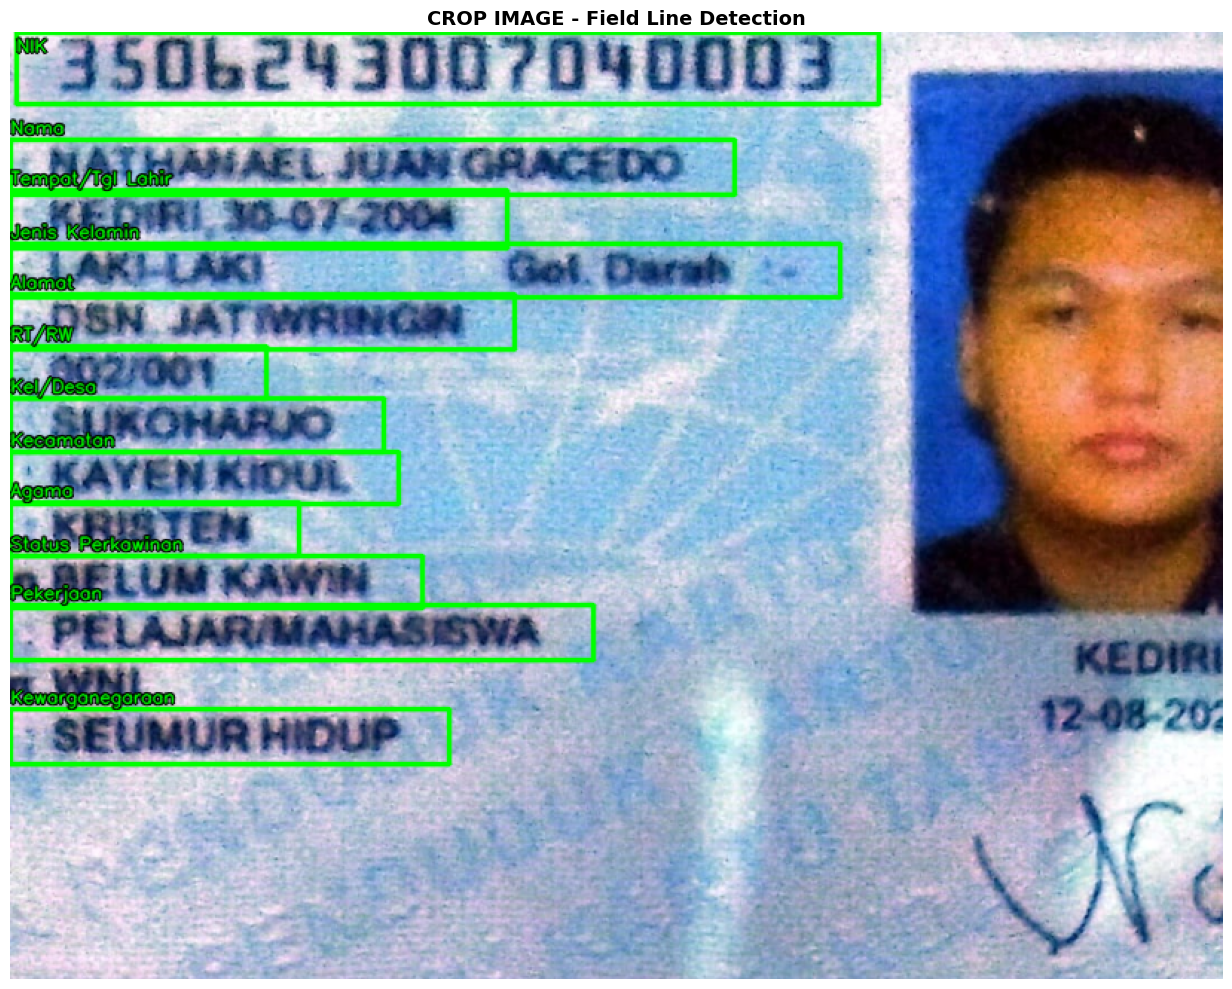

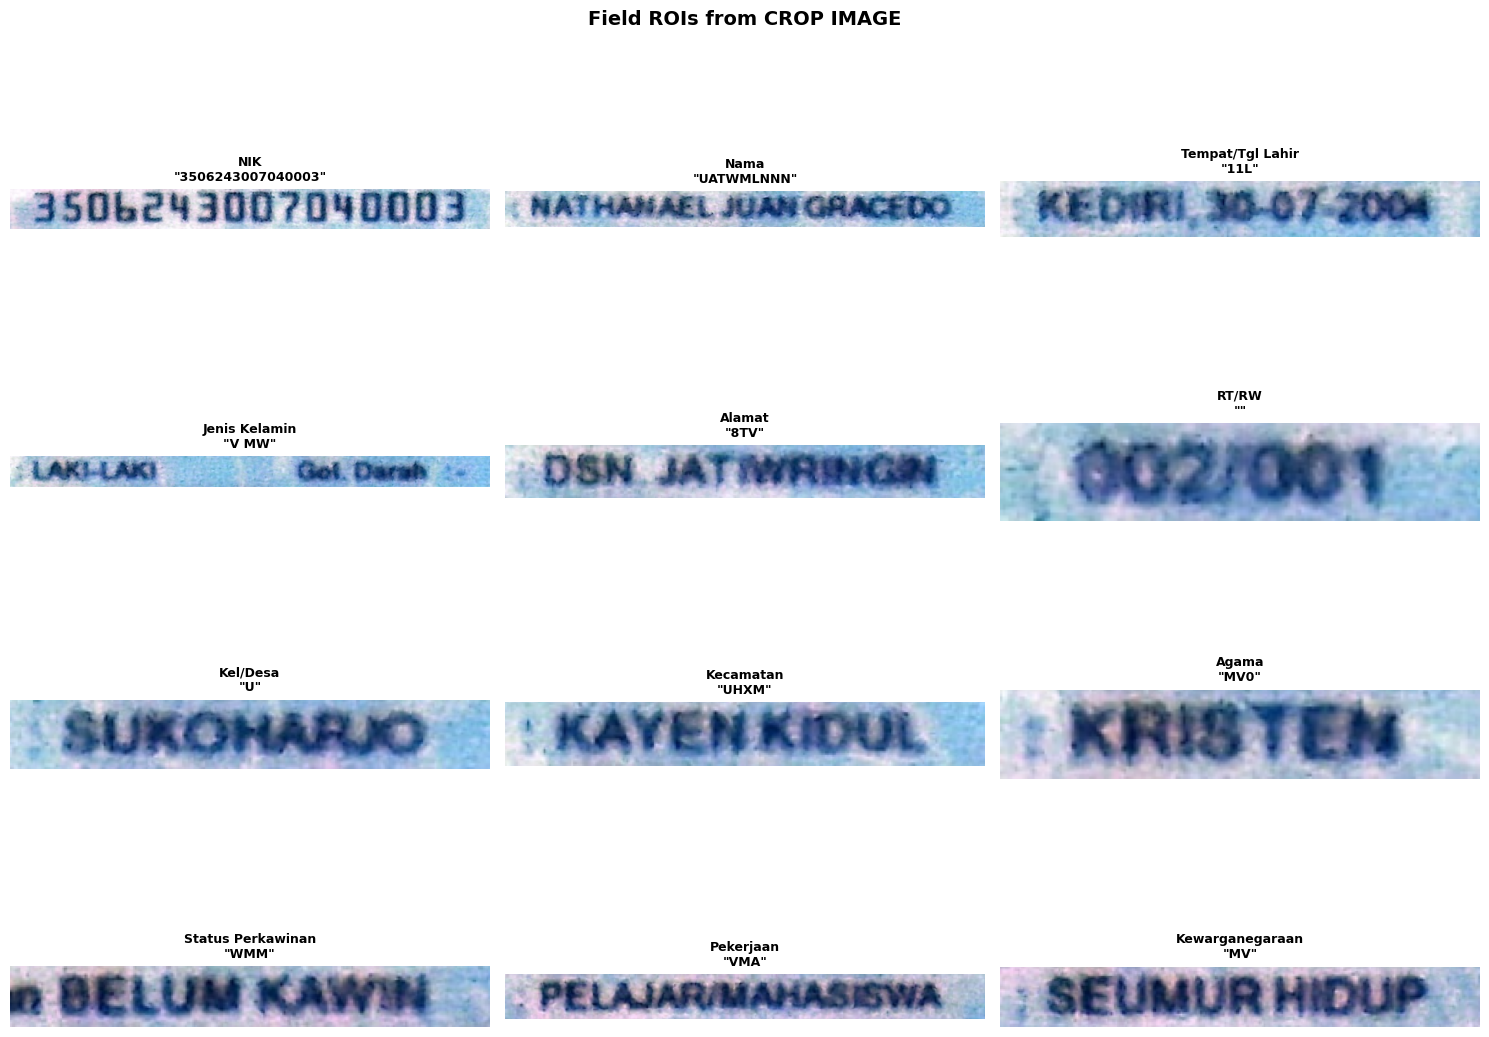


CHARACTER SEGMENTATION DETAILS

NIK: 16 chars -> "3506243007040003"


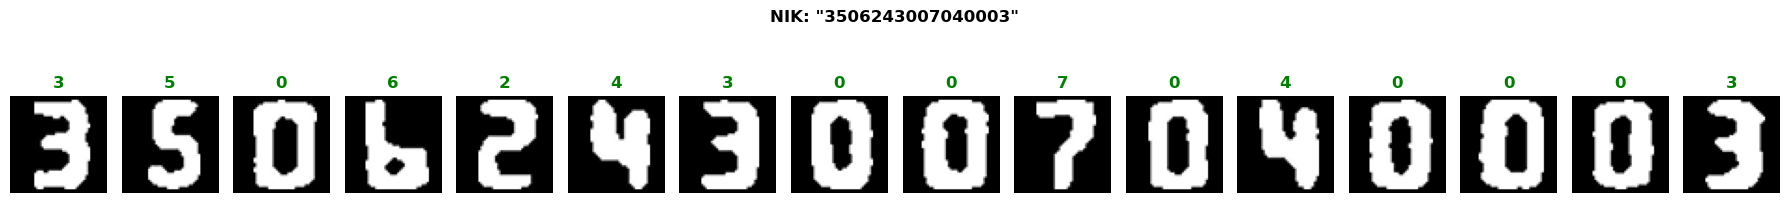

Nama: 9 chars -> "UATWMLNNN"


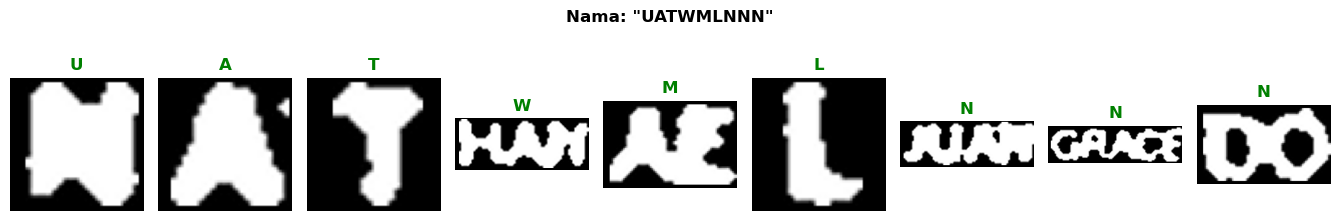

Tempat/Tgl Lahir: 3 chars -> "11L"


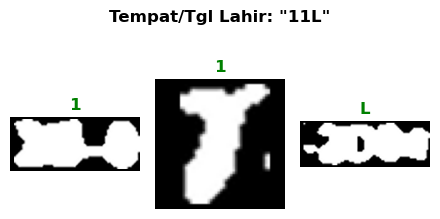

Jenis Kelamin: 3 chars -> "V MW"


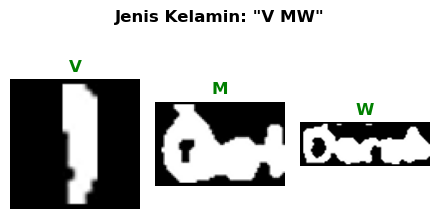

Alamat: 3 chars -> "8TV"


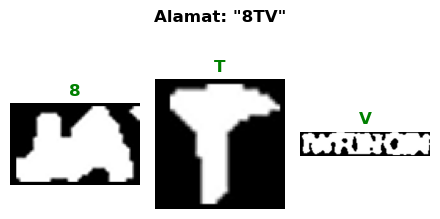

RT/RW: 1 chars -> ""


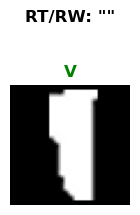

Kel/Desa: 1 chars -> "U"


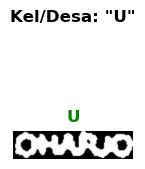

Kecamatan: 4 chars -> "UHXM"


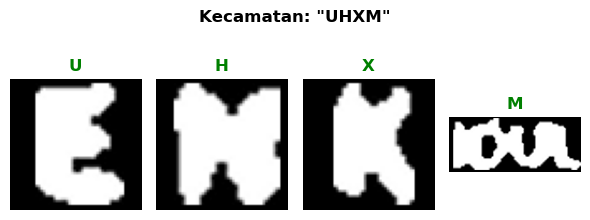

Agama: 3 chars -> "MV0"


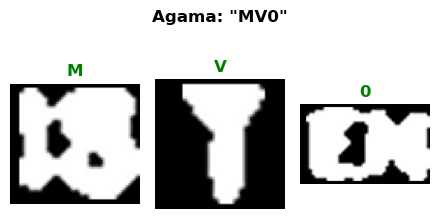

Status Perkawinan: 3 chars -> "WMM"


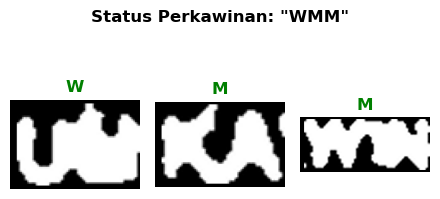

Pekerjaan: 3 chars -> "VMA"


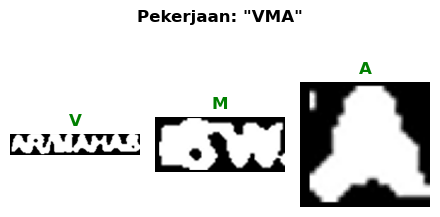

Kewarganegaraan: 2 chars -> "MV"


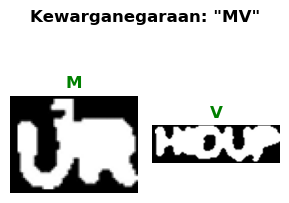


✓ EKSTRAKSI SELESAI - HANYA MENGGUNAKAN CROP IMAGE


In [8]:
# 7) KTP Field Extraction - Extract values from cropped KTP region
import json

# Initialize pipeline
PIPE = OCRKTPPipeline()

# Load trained model
model_file = 'digit_svm_best_ml.xml'
config_file = 'digit_feature_config.json'

if os.path.exists(model_file) and os.path.exists(config_file):
    # Load config
    with open(config_file, 'r', encoding='utf-8') as f:
        cfg = json.load(f)
    
    # Load feature config
    feat_cfg = FeatureConfig(
        method=cfg.get('method', 'hog'),
        hog_orientations=cfg.get('hog_orientations', 9),
        hog_cell=tuple(cfg.get('hog_cell', (8,8))),
        hog_block=tuple(cfg.get('hog_block', (16,16))),
        hog_stride=tuple(cfg.get('hog_stride', (8,8))),
        resize_to=int(cfg.get('resize_to', 48)),
        deskew=bool(cfg.get('deskew', True)),
        normalize=bool(cfg.get('normalize', True))
    )
    
    # Load class mapping
    idx_to_class = {int(k): v for k, v in cfg.get('idx_to_class', {}).items()}
    
    # Load classifier
    clf = cv.ml.SVM_load(model_file)
    PIPE.set_model(clf, feat_cfg, 'svm', idx_to_class)
    
    print(f'✓ Model loaded: {model_file}')
    print(f'✓ Classes: {sorted(idx_to_class.values())}')
else:
    print('✗ Model not found. Please run training cell (cell 9) first.')

# Test image path
TEST_IMAGE_PATH = 'l:\\Four Heavenly Principle\\PCVK\\test\\ktp-test.jpg'

if os.path.exists(TEST_IMAGE_PATH) and PIPE.clf is not None:
    print(f'\n{"="*60}')
    print('EKSTRAKSI KTP FIELD VALUES')
    print(f'{"="*60}\n')
    
    # Load image
    img = imread_color(TEST_IMAGE_PATH)
    print(f'Image loaded: {img.shape[1]}x{img.shape[0]} pixels')
    
    # Extract fields from CROP IMAGE
    seg_cfg = SegmentationConfig(target_height=48, min_char_width=4, min_char_area=30, pad=2)
    field_data = PIPE.extract_fields(img, seg_cfg=seg_cfg)
    
    info_roi = field_data['info_roi']
    crop_rect = field_data['crop_rect']
    line_boxes = field_data['line_boxes']
    fields = field_data['fields']
    
    print(f'Crop region: x={crop_rect[0]}, y={crop_rect[1]}, w={crop_rect[2]}, h={crop_rect[3]}')
    print(f'Detected {len(line_boxes)} field lines\n')
    
    # Display results in JSON format
    print('HASIL EKSTRAKSI (JSON):')
    print(json.dumps(fields, indent=2, ensure_ascii=False))
    
    # Visualization 1: Crop image with field bounding boxes
    vis_crop = info_roi.copy()
    for fname, (x, y, w, h) in line_boxes.items():
        # Draw green box
        cv.rectangle(vis_crop, (x, y), (x+w, y+h), (0, 255, 0), 2, cv.LINE_AA)
        # Add field name label
        (tw, th_text), _ = cv.getTextSize(fname, cv.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        label_y = max(y - 4, th_text + 4)
        cv.putText(vis_crop, fname, (x, label_y), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 2, cv.LINE_AA)
        cv.putText(vis_crop, fname, (x, label_y), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv.LINE_AA)
    
    plt.figure(figsize=(14, 10))
    plt.imshow(cv.cvtColor(vis_crop, cv.COLOR_BGR2RGB))
    plt.title('CROP IMAGE - Field Line Detection', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: Per-field ROIs with values
    field_names = list(line_boxes.keys())
    n_fields = len(field_names)
    
    if n_fields > 0:
        cols = 3
        rows = int(np.ceil(n_fields / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten() if n_fields > 1 else [axes]
        
        for i, fname in enumerate(field_names):
            x, y, w, h = line_boxes[fname]
            field_roi = info_roi[y:y+h, x:x+w]
            value = fields.get(fname, '')
            
            axes[i].imshow(cv.cvtColor(field_roi, cv.COLOR_BGR2RGB))
            axes[i].set_title(f'{fname}\n"{value}"', fontsize=9, fontweight='bold')
            axes[i].axis('off')
        
        # Hide unused subplots
        for i in range(n_fields, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Field ROIs from CROP IMAGE', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Visualization 3: Per-character segmentation for each field
    print(f'\n{"="*60}')
    print('CHARACTER SEGMENTATION DETAILS')
    print(f'{"="*60}\n')
    
    for fname in field_names:
        if fname not in line_boxes:
            continue
        
        x, y, w, h = line_boxes[fname]
        field_box = (x, y, w, h)
        
        # Extract character images
        field_chars, char_boxes = extract_field_char_images(info_roi, field_box, seg_cfg, field_name=fname)
        
        if not field_chars:
            print(f'{fname}: No characters detected')
            continue
        
        # Predict characters
        preds = predict_digit_chars(field_chars, PIPE.clf, PIPE.feat_cfg, PIPE.classifier_type, PIPE.idx_to_class)
        raw_text = _reconstruct_text(preds, char_boxes)
        recognized = _clean_field_value(fname, raw_text)
        
        print(f'{fname}: {len(field_chars)} chars -> "{recognized}"')
        
        # Visualize characters
        n_chars = len(field_chars)
        fig, axes = plt.subplots(1, n_chars, figsize=(min(18, 1.5 * n_chars), 2.5))
        if n_chars == 1:
            axes = [axes]
        
        for j, ch in enumerate(field_chars):
            axes[j].imshow(ch, cmap='gray')
            pred = preds[j] if j < len(preds) else '?'
            axes[j].set_title(f'{pred}', fontsize=12, fontweight='bold', color='green')
            axes[j].axis('off')
        
        fig.suptitle(f'{fname}: "{recognized}"', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    print(f'\n{"="*60}')
    print('✓ EKSTRAKSI SELESAI - HANYA MENGGUNAKAN CROP IMAGE')
    print(f'{"="*60}')
    
else:
    if not os.path.exists(TEST_IMAGE_PATH):
        print(f'✗ Test image not found: {TEST_IMAGE_PATH}')
    if PIPE.clf is None:
        print('✗ Model not loaded. Train model first.')

Eval Accuracy: 0.983765783266269


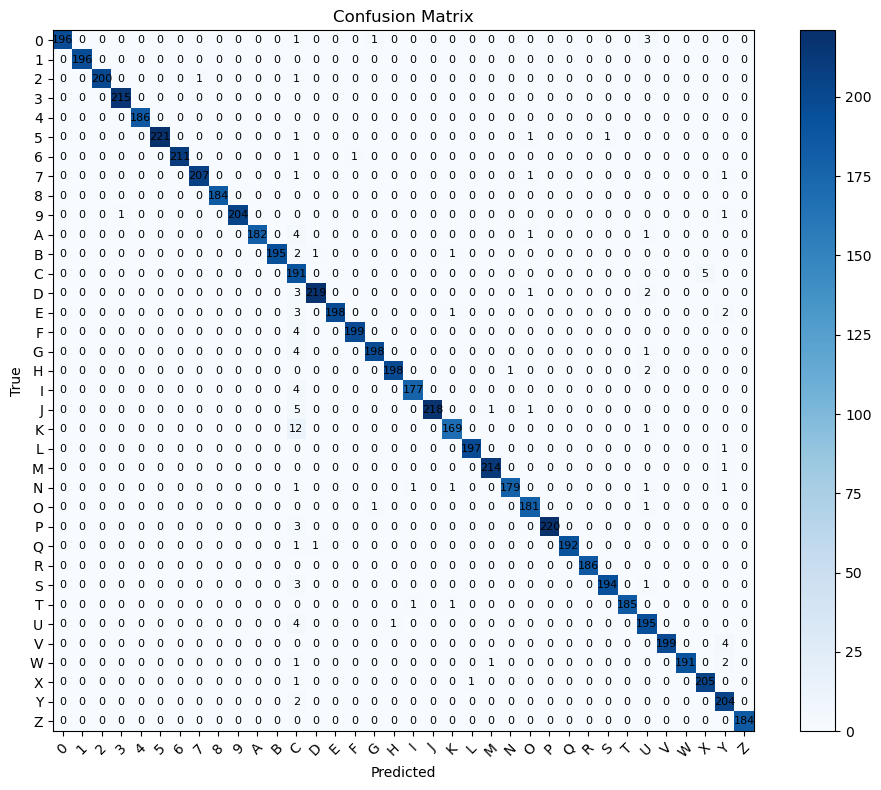

In [9]:
# 8) Optional: quick evaluation on a held-out split (confusion matrix)
try:
    from collections import defaultdict
    feat_cfg_eval = PIPE.feat_cfg if getattr(PIPE, 'feat_cfg', None) else FeatureConfig()
    X, y, class_to_idx = load_digit_dataset(feat_cfg=feat_cfg_eval, img_size=(feat_cfg_eval.resize_to, feat_cfg_eval.resize_to))
    Xtr, Xte, ytr, yte = _train_test_split(X, y, test_size=0.2, seed=42)
    if PIPE.clf is None:
        # Temporary SVM to evaluate
        tmp = cv.ml.SVM_create(); tmp.setType(cv.ml.SVM_C_SVC); tmp.setKernel(cv.ml.SVM_RBF); tmp.setC(1.0); tmp.setGamma(0.01)
        tmp.train(Xtr, cv.ml.ROW_SAMPLE, ytr)
        clf_eval = tmp
    else:
        clf_eval = PIPE.clf
    _, ypred = clf_eval.predict(Xte)
    ypred = ypred.flatten().astype(np.int32)
    acc = float((ypred == yte).mean()) if len(yte) else 0.0
    print('Eval Accuracy:', acc)
    
    # Confusion matrix
    labels = sorted(list(set(yte.tolist()+ypred.tolist())))
    idx = {c:i for i,c in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    for yt, yp in zip(yte, ypred):
        cm[idx[yt], idx[yp]] += 1
    
    # Map indices to class names for display
    idx_to_class_eval = {idx: cls for cls, idx in class_to_idx.items()}
    label_names = [idx_to_class_eval.get(i, str(i)) for i in labels]
    
    plt.figure(figsize=(10,8))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(range(len(labels)), label_names, rotation=45)
    plt.yticks(range(len(labels)), label_names)
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, str(cm[i,j]), ha='center', va='center', color='black', fontsize=8)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Evaluation skipped:', e)
